In [71]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10, 5] #default figure size

In [72]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [73]:
# Extraction was done by Barry Becker from the 1994 Census database.
# Prediction task is to determine whether a person makes over 50K a year.

# summary of algorithms run with error rates after unknown removal
# Conversion of original data as follows:
# 1. Discretized agrossincome into two ranges with threshold 50
# 2. Convert U.S. to US to avoid periods.
# 3. Convert Unknown to "?"
# 4. Run MLC++ GenCVFiles to generate data test.

# Description of fnlwgt (final weight)
# The weights on the CPS files are controlled to independent estimates of the
# civilian noninstitutional population of the US.
# Assumption: People with similar demographic characteristics should have similar # weights.  

In [74]:
# read the train data
header=['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','target']
df = pd.read_csv('data/adult.data.csv',names=header)

In [75]:
# test data is provided separately
# read the test data
test_df = pd.read_csv('data/adult.test.csv',names=header)
# drop the first row
test_df = test_df.iloc[1:]

In [76]:
test_df['age'] = test_df['age'].astype(float)

In [77]:
# combine the train and test data
df = pd.concat([df,test_df])

In [78]:
# train
df.shape

(48842, 15)

In [79]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48842 entries, 0 to 16281
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             48842 non-null  float64
 1   workclass       48842 non-null  object 
 2   fnlwgt          48842 non-null  float64
 3   education       48842 non-null  object 
 4   education-num   48842 non-null  float64
 5   marital-status  48842 non-null  object 
 6   occupation      48842 non-null  object 
 7   relationship    48842 non-null  object 
 8   race            48842 non-null  object 
 9   sex             48842 non-null  object 
 10  capital-gain    48842 non-null  float64
 11  capital-loss    48842 non-null  float64
 12  hours-per-week  48842 non-null  float64
 13  native-country  48842 non-null  object 
 14  target          48842 non-null  object 
dtypes: float64(6), object(9)
memory usage: 6.0+ MB


In [81]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [82]:
# since fnlwgt is an estimate by gov
# we suspect the accruacy of it
# so we drop it
df.drop(columns=['fnlwgt'], inplace=True)

In [83]:
# since education is highly correlated with education-num
# we decide to drop it
df.drop(columns=['education'], inplace=True)

In [84]:
# replace missing data (comes with " ?") with NaN
df.replace(" ?", np.nan, inplace = True)
df.isnull().sum()

age                  0
workclass         2799
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
target               0
dtype: int64

In [85]:
# impute missing values with mode
for col in ['workclass', 'occupation', 'native-country']:
    df[col].fillna(df[col].mode()[0], inplace=True)
df.isnull().sum()
# now we have no missing values

age               0
workclass         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
target            0
dtype: int64

In [86]:
# create capital_change to summarize capital_loss & capital_gain
df['capital_change'] = df['capital-gain']-df['capital-loss']
for i in ['capital-loss','capital-gain']:
    df.drop(columns=[i], inplace=True)

In [87]:
df.target.value_counts()

 <=50K     24720
 <=50K.    12435
 >50K       7841
 >50K.      3846
Name: target, dtype: int64

In [88]:
# encode target feature
df['target'] = df['target'].map({' <=50K': 0, ' >50K': 1,' <=50K.': 0, ' >50K.': 1})

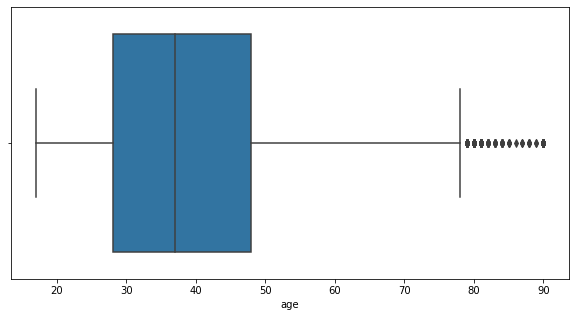

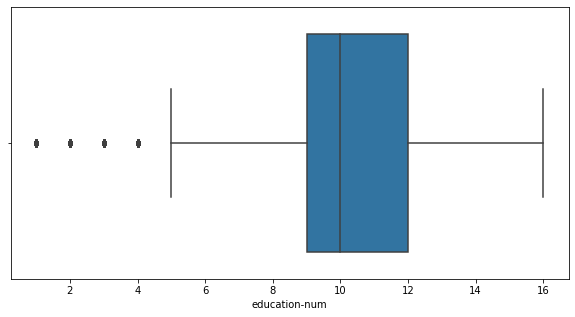

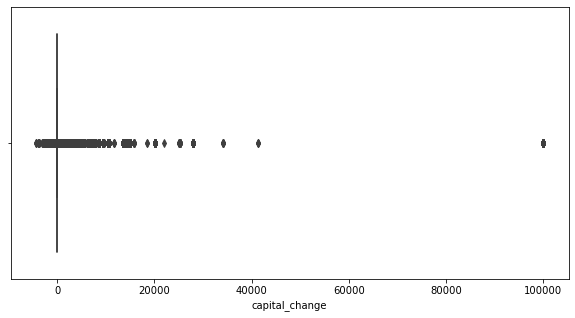

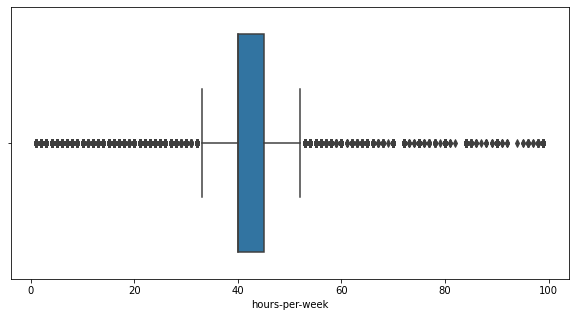

In [89]:
# outliers
features = ['age','education-num','capital_change','hours-per-week']
for i in features:
    sns.boxplot(df[i])
    plt.show()

In [90]:
# big big thanks to Matthew
# for capital_change, we can divid it into three ordinal categories



In [91]:
#from scipy import stats
#from sklearn.compose import ColumnTransformer, make_column_transformer
#from sklearn.pipeline import Pipeline
#from sklearn.ensemble import IsolationForest

# identify outliers in the training dataset
#out = df[['age','education-num','capital_change','hours-per-week']]
#df_out = df.drop(columns=['age','education-num','capital_change','hours-per-week'])

#print(out.shape)
# Using Z-score
#z = np.abs(stats.zscore(out))
#print(z)

# defining threshold
#threshold = 3
#print(np.where(z>3))
#print(z[48841][3])

#out = out[(z<3).all(axis=1)]
#print(out.shape)

#df = df.join(out)
#df

# z[row][col]

#numeric_features = ['age','education-num','capital_change','hours-per-week']
#numeric_transformer = Pipeline(steps=[
    #('iso', IsolationForest(contamination=0.1))])

#preprocessor = ColumnTransformer(
    #transformers=[
        #('num', numeric_transformer, numeric_features)])

#clf = Pipeline(steps=[('preprocessor', preprocessor)])
#clf.fit(df)

#preprocess = make_column_transformer(
    #(['age','education-num','capital_change','hours-per-week'], IsolationForest(contamination=0.1)),
#)

#preprocess.fit_transform(df)

EDA

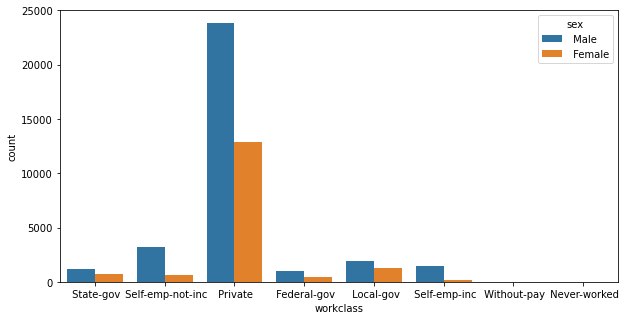

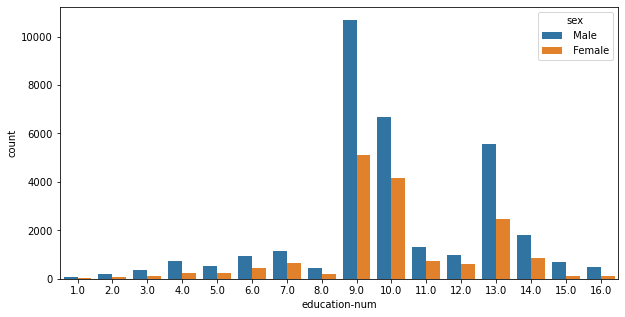

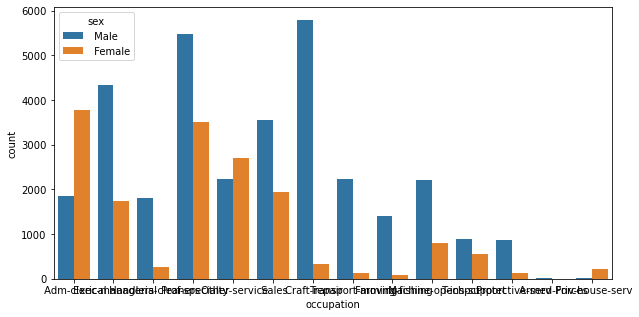

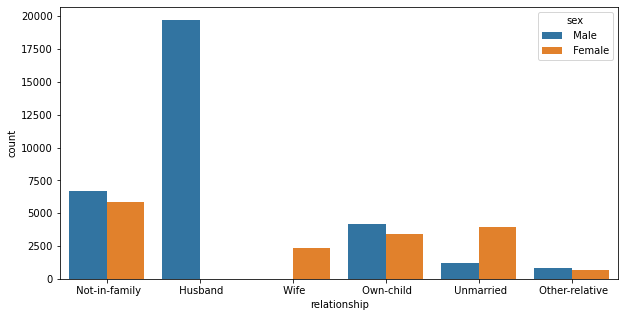

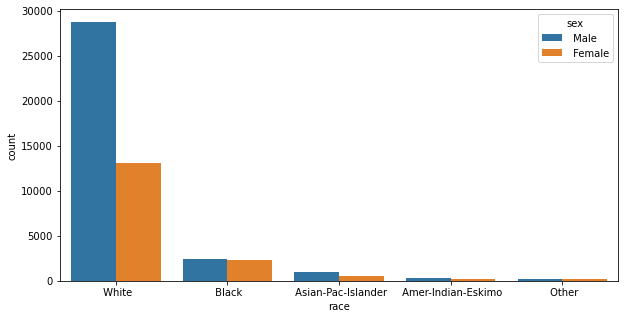

In [92]:
s = ['workclass','education-num','occupation','relationship','race']
for i in s:
    sns.countplot(data = df, x = i , hue ='sex')
    plt.show()
# workclass - private (male)
# education - HS-grad -> Some-collage -> Bachelors
# Occupation - male -> Craft-repair , female -> Adm-clerical , mixed -> Prof-specialty
# race - White(mainly) -> Black
# Country - USA (mainly)

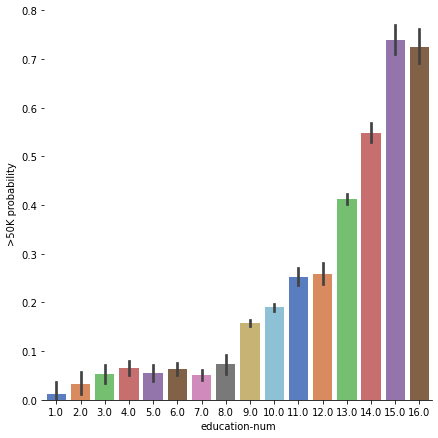

In [93]:
# Explore education_num vs Income
g = sns.factorplot(x="education-num",y="target",data=df,kind="bar",size = 6,palette = "muted")
g.despine(left=True)
g = g.set_ylabels(">50K probability")

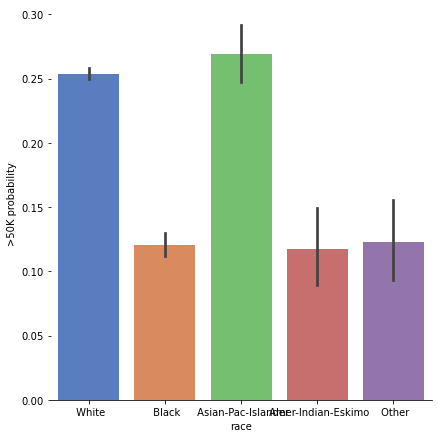

In [94]:
# Explore race vs Income
g = sns.factorplot(x="race",y="target",data=df,kind="bar",size = 6,palette = "muted")
g.despine(left=True)
g = g.set_ylabels(">50K probability")

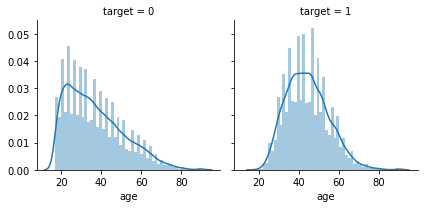

In [95]:
# Explore Age vs income
g = sns.FacetGrid(df, col='target')
g = g.map(sns.distplot, "age")
plt.show()

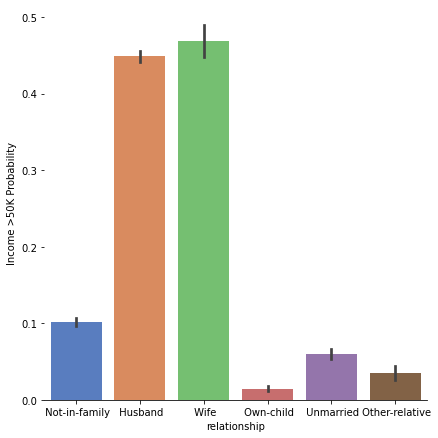

In [96]:
# Explore Relationship vs Income
g = sns.factorplot(x="relationship",y="target",data=df,kind="bar", size = 6 ,palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Income >50K Probability")
plt.show()

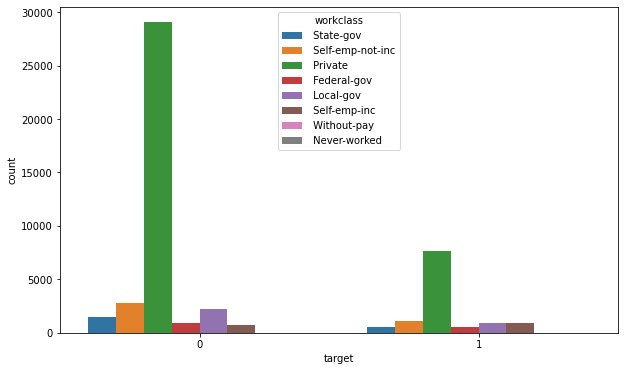

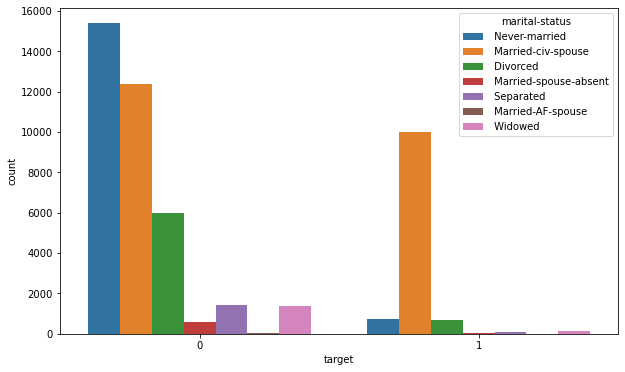

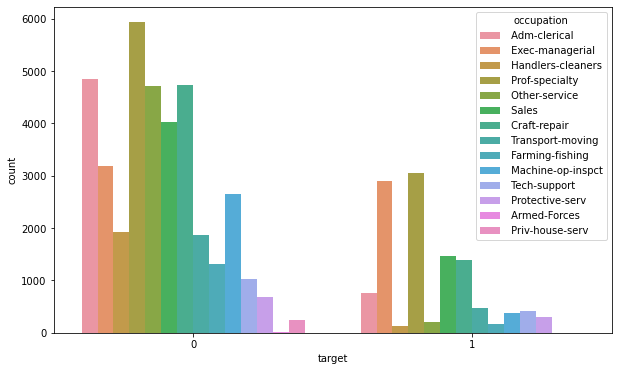

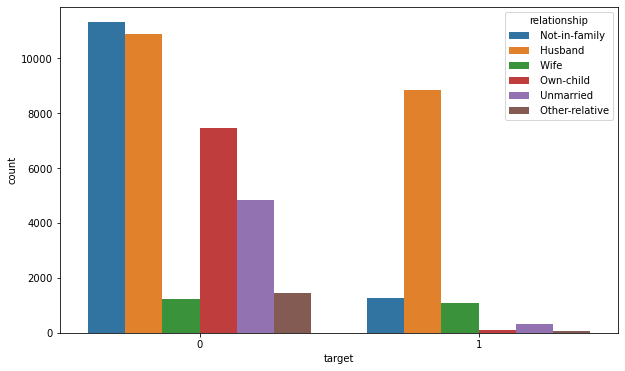

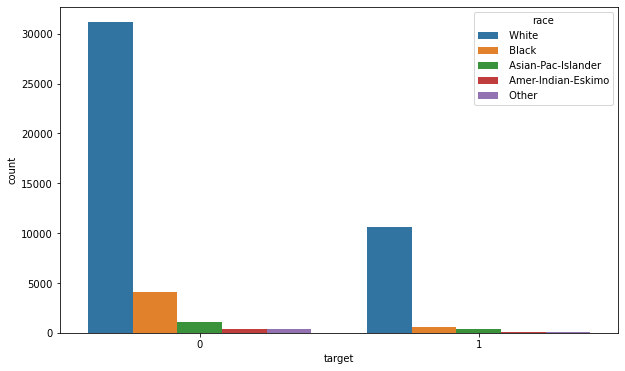

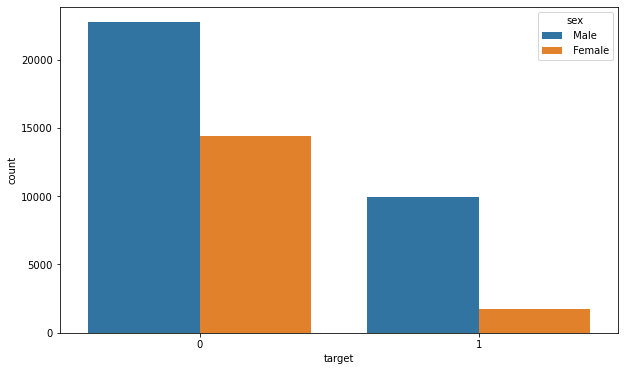

In [97]:
for col in df[['workclass','marital-status','occupation','relationship','race','sex']]:
    fig, axes = plt.subplots(figsize = (10,6))
    sns.countplot(data = df, x = "target", hue = col)
    plt.show()

In [98]:
df['native-country'].value_counts()
# native-country is mainly United-States

 United-States                 44689
 Mexico                          951
 Philippines                     295
 Germany                         206
 Puerto-Rico                     184
 Canada                          182
 El-Salvador                     155
 India                           151
 Cuba                            138
 England                         127
 China                           122
 South                           115
 Jamaica                         106
 Italy                           105
 Dominican-Republic              103
 Japan                            92
 Guatemala                        88
 Poland                           87
 Vietnam                          86
 Columbia                         85
 Haiti                            75
 Portugal                         67
 Taiwan                           65
 Iran                             59
 Nicaragua                        49
 Greece                           49
 Peru                             46
 

In [99]:
# encode for categorical features
df = pd.get_dummies(df,drop_first=True)

In [100]:
df.head()

,age,education-num,hours-per-week,target,capital_change,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39.0,13.0,40.0,0,2174.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50.0,13.0,13.0,0,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,38.0,9.0,40.0,0,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53.0,7.0,40.0,0,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28.0,13.0,40.0,0,0.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48842 entries, 0 to 16281
Data columns (total 81 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   age                                         48842 non-null  float64
 1   education-num                               48842 non-null  float64
 2   hours-per-week                              48842 non-null  float64
 3   target                                      48842 non-null  int64  
 4   capital_change                              48842 non-null  float64
 5   workclass_ Local-gov                        48842 non-null  uint8  
 6   workclass_ Never-worked                     48842 non-null  uint8  
 7   workclass_ Private                          48842 non-null  uint8  
 8   workclass_ Self-emp-inc                     48842 non-null  uint8  
 9   workclass_ Self-emp-not-inc                 48842 non-null  uint8  
 10  workclass_

In [102]:
# target and features setting
X = df.drop(['target'],axis=1)
y = df['target']

In [103]:
X

,age,education-num,hours-per-week,capital_change,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39.0,13.0,40.0,2174.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,50.0,13.0,13.0,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,38.0,9.0,40.0,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53.0,7.0,40.0,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28.0,13.0,40.0,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16277,39.0,13.0,36.0,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
16278,64.0,9.0,40.0,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
16279,38.0,13.0,50.0,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
16280,44.0,13.0,40.0,5455.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [104]:
df['target']

0        0
1        0
2        0
3        0
4        0
        ..
16277    0
16278    0
16279    0
16280    0
16281    1
Name: target, Length: 48842, dtype: int64

In [105]:
y

0        0
1        0
2        0
3        0
4        0
        ..
16277    0
16278    0
16279    0
16280    0
16281    1
Name: target, Length: 48842, dtype: int64

In [106]:
# splitting data
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [107]:
###
# you can try your models start from here
###

In [108]:
# transformation and scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [109]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(39073, 80)
(39073,)
(9769, 80)
(9769,)


# KNN


In [110]:
## import the knn model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
## try running from k=1 through 25 and record the accuaracy 
#k_range = range(1,26) ## setting k from 1-25
# score={} ## record the accuracy
# score_list=[]
knn = KNeighborsClassifier(n_neighbors=14, weights = 'uniform' ) ## k=3
knn.fit(X_train, y_train) ## learn from training dataset
y_pred=knn.predict(X_test)
score = metrics.accuracy_score(y_test,y_pred)
#score_list.append(metrics.accuracy_scorec(y_test,y_pred))
    

In [111]:
score

0.8350905926911659

In [112]:
from sklearn.metrics import classification_report

In [113]:
print(classification_report(y_test,y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.863     0.929     0.895      7383
           1      0.712     0.545     0.617      2386

    accuracy                          0.835      9769
   macro avg      0.788     0.737     0.756      9769
weighted avg      0.826     0.835     0.827      9769



In [114]:
# KNN
# accrucy score for Kneighbor Classifier: 83.5% (0.8350905926911659)
# F1 score for Kneighbor Classifier: 87%
# which is similiar with baseline score 83.5%

In [ ]:
## for loop
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
## try running from k=1 through 25 and record the accuaracy 
k_range = range(10,21) ## setting k from 1-25
scores={} ## record the accuracy
scores_list=[]
count = 0
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train) ## learn from training dataset
    y_pred=knn.predict(X_test)
    scores[k] = metrics.accuracy_score(y_test,y_pred)
    scores_list.append(metrics.accuracy_score(y_test,y_pred))
    print(count)

In [ ]:
plt.plot(k_range,scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [ ]:
scores

In [ ]:
knn = KNeighborsClassifier(n_neighbors=14) ## make an object
knn.fit(X_train,y_train)

In [ ]:
classes = {0:'<=50k', 1:'>50k'}
y_predict = knn.predict(X_test)
for i in range(41):
    print(classes[y_predict[i]])

# Tree


In [116]:
# Import module for fitting
from sklearn.tree import DecisionTreeClassifier

dtreemodel = DecisionTreeClassifier(criterion = "entropy",splitter = "best", max_depth = 10, min_samples_split = 2, min_samples_leaf=2, random_state = 42)
# Fit the model using the training data
# X_train -> parameter supplies the data features
# y_train -> parameter supplies the target labels
dtreemodel.fit(X_train, y_train)
print(dtreemodel.score(X_test, y_test))

0.8565871634763026


In [122]:
#print(classification_report(y_test,y_pred, digits=3))

In [51]:
dtreemodel.classes_

array([0, 1], dtype=int64)

In [52]:
dtreemodel.feature_importances_

array([7.81467272e-02, 1.76806651e-01, 4.15022812e-02, 2.75737189e-01,
       6.79758608e-04, 0.00000000e+00, 7.91475986e-04, 1.71207177e-04,
       4.57543175e-03, 1.61721532e-04, 0.00000000e+00, 6.22452573e-04,
       3.92267089e-01, 0.00000000e+00, 2.40670729e-04, 0.00000000e+00,
       2.43996419e-04, 0.00000000e+00, 2.18945376e-04, 7.55366777e-03,
       8.67369675e-04, 3.11103772e-04, 8.19644024e-04, 5.49429483e-03,
       0.00000000e+00, 1.01698512e-03, 6.58897321e-06, 5.54935565e-04,
       1.00615289e-03, 5.07874068e-04, 2.27676581e-03, 2.38553352e-04,
       3.46331743e-04, 0.00000000e+00, 2.25590802e-03, 5.26910002e-04,
       8.00869970e-04, 0.00000000e+00, 1.93537887e-04, 1.64225200e-03,
       2.01122203e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [53]:
predictions = dtreemodel.predict(X_test)

In [54]:
print(X_test[0:3])
print(predictions[0,3])

[[-1.28543411 -0.02836074 -0.03423253 -0.13216379 -0.26072365 -0.01431038
   0.57005054 -0.18625263 -0.2925788  -0.20324369 -0.0189323  -0.02725347
  -0.91435821 -0.1147718   1.41946891 -0.17899467 -0.1787661  -0.01824339
  -0.37778204 -0.37570028 -0.17746603 -0.2126868  -0.25729194 -0.33591983
  -0.06990318 -0.47374752 -0.14522127 -0.35709627 -0.17382733 -0.22532901
  -0.59215842 -0.17853728 -0.4291548   2.90795384 -0.22192215 -0.17891851
   3.06504809 -0.09072711 -2.42767652 -1.41930504 -0.06081975 -0.04910759
  -0.04385403 -0.05409393 -0.04778062 -0.03078706 -0.05573497 -0.05240213
  -0.02862955 -0.06551639 -0.03280347 -0.04266637 -0.0405049  -0.00505903
  -0.01959705 -0.02426908 -0.02205688 -0.05264711 -0.03507108 -0.02479138
  -0.04613839 -0.0472395  -0.04266637 -0.02318932 -0.14159662 -0.03319212
  -0.02205688 -0.02951142 -0.07795306 -0.04175364 -0.03788498 -0.06060742
  -0.02146831 -0.04778062 -0.03470339 -0.02479138 -0.02373533  0.30573031
  -0.04326424 -0.02146831]
 [-1.212410

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
from sklearn import tree
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(dtreemodel,
                              out_file=f,
                              max_depth = 10,
                              impurity = True,
                              feature_names= X.columns ,
                              class_names=['<=50k','>50k'],
                              rounded = True,
                              filled= True )

In [ ]:
plt.subplots(figsize = (400,200))
tree.plot_tree(dtreemodel)
plt.show()

In [120]:
#dtreemodel.score(X_test, y_test)

In [121]:
#print(classification_report(y_test,y_pred, digits=3))

In [ ]:
# List of values to try for max_depth:
max_depth_range = list(range(1, 11))
# List to store the accuracy for each value of max_depth:
accuracy = []
for depth in max_depth_range:
    
    clf = DecisionTreeClassifier(max_depth = depth, random_state=0)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    accuracy.append(score)

In [ ]:
plt.xlabel("max_depth")
plt.ylabel("max_depth")
plt.plot(max_depth_range,accuracy)

In [123]:
# Import module for fitting
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
dtreemodel = DecisionTreeClassifier(max_depth=10)
# Fit the model using the training data
# X_train -> parameter supplies the data features
# y_train -> parameter supplies the target labels
dtreemodel.fit(X_train, y_train)

predictions = dtreemodel.predict(X_test)
print(f"{accuracy_score(y_test, predictions)}")

0.8586344559320299


In [124]:
print(classification_report(y_test,y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.863     0.929     0.895      7383
           1      0.712     0.545     0.617      2386

    accuracy                          0.835      9769
   macro avg      0.788     0.737     0.756      9769
weighted avg      0.826     0.835     0.827      9769



In [57]:
classes = {0:'<=50k', 1:'>50k'}
predictions = dtreemodel.predict(X_test)
for i in range(41):
    print(classes[predictions[i]])

<=50k
<=50k
<=50k
<=50k
>50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k
>50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k
>50k
>50k
<=50k
<=50k
<=50k
<=50k
>50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k


# Random Forests

In [125]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rnd_clf = RandomForestClassifier(n_estimators=70, max_leaf_nodes=1000, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

0.8606817483877572


In [127]:
print(classification_report(y_test,y_pred_rf, digits=3))

              precision    recall  f1-score   support

           0      0.878     0.948     0.911      7383
           1      0.786     0.591     0.674      2386

    accuracy                          0.861      9769
   macro avg      0.832     0.769     0.793      9769
weighted avg      0.855     0.861     0.854      9769



In [128]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2), n_estimators=1000,learning_rate=0.05, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.05, n_estimators=1000, random_state=42)

In [129]:
y_pred = ada_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8700992936841028


In [130]:
print(classification_report(y_test,y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.892     0.943     0.916      7383
           1      0.785     0.645     0.708      2386

    accuracy                          0.870      9769
   macro avg      0.838     0.794     0.812      9769
weighted avg      0.865     0.870     0.866      9769



In [131]:
for i in range(41):
    print(classes[y_pred[i]])

<=50k
<=50k
<=50k
<=50k
>50k
>50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k
>50k
<=50k
<=50k
<=50k
<=50k
>50k
<=50k
<=50k
<=50k
>50k
>50k
<=50k
<=50k
<=50k
>50k
>50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k
<=50k


# LogisticRegression

In [132]:
# Import module for fitting
from sklearn.linear_model import LogisticRegression

# Create instance of LogisticRegression
logmodel = LogisticRegression()

logmodel.fit(X_train, y_train)

logmodel.score(X_test, y_test)

0.8421537516634251

In [135]:
y_pred = logmodel.predict(X_test)

In [136]:
print(classification_report(y_test,y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.875     0.923     0.898      7383
           1      0.713     0.593     0.647      2386

    accuracy                          0.842      9769
   macro avg      0.794     0.758     0.773      9769
weighted avg      0.835     0.842     0.837      9769



In [ ]:
#END